In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from causalgraphicalmodels import CausalGraphicalModel
import graphviz as gr
import statistics


In [246]:
file_path_games = "dataset/data_files/3data_matches.csv"
file_path_hero_ids = "heroes.json"
file_path_players = "dataset/data_files/3data_players.csv"
file_path_hero_rankings = "dataset/data_files/3data_hero_rankings.csv"

In [247]:
games_df = pd.read_csv(file_path_games)
heroes_df = pd.read_json(file_path_hero_ids)
player_df = pd.read_csv(file_path_players)
hero_rankings_df = pd.read_csv(file_path_hero_rankings)

In [248]:
games_df.head()

,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,account_id,hero_id,win
0,6575515114,1652868104,3478,1,2,1,1284611820,13,True
1,6575515114,1652868104,3478,1,2,1,412320425,15,True
2,6575515114,1652868104,3478,1,2,1,225617497,123,True
3,6575515114,1652868104,3478,1,2,1,348236339,129,True
4,6575515114,1652868104,3478,1,2,1,1262266956,27,True


In [249]:
heroes_df.head()

,id,name,localized_name,primary_attr,attack_type,roles,legs
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"[Carry, Escape, Nuker]",2
1,2,npc_dota_hero_axe,Axe,str,Melee,"[Initiator, Durable, Disabler, Jungler, Carry]",2
2,3,npc_dota_hero_bane,Bane,int,Ranged,"[Support, Disabler, Nuker, Durable]",4
3,4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"[Carry, Disabler, Jungler, Nuker, Initiator]",2
4,5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"[Support, Disabler, Nuker, Jungler]",2


In [250]:
player_df.head(10)

,account_id,competitive_rank,leaderboard_rank,mmr_estimate,rank_tier,solo_competitive_rank,tracked_until
0,1284611820,None,None,{'estimate': 3723},None,None,None
1,412320425,None,4370,{'estimate': 3913},80,None,None
2,225617497,4324,2047,{'estimate': 3762},80,3478,1654960229
3,348236339,None,None,{'estimate': 3839},None,None,None
4,1262266956,None,None,{'estimate': 3797},None,None,None
5,318051460,None,None,{'estimate': 3813},72,None,None
6,1050127319,None,None,{'estimate': 3667},75,None,None
7,1255727750,None,None,{'estimate': 3807},80,None,None
8,420936449,None,None,{'estimate': 3805},80,None,None
9,1106336680,None,None,{'estimate': 3810},55,None,None


In [251]:
hero_rankings_df.head()

,account_id,card,hero_id,percent_rank,score
0,1284611820,2928000,13,0.980874,5294.675297
1,412320425,3420000,15,0.891228,4340.800355
2,225617497,1372000,123,0.997085,6542.116661
3,348236339,3132000,129,0.928480,4698.927311
4,1262266956,4680000,27,0.932479,4799.287729


In [252]:
games_df.tail()

,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,account_id,hero_id,win
4186,6521088403,1649767607,4327,5,2,1,219006194,70,True
4187,6521088403,1649767607,4327,5,2,1,425928431,126,True
4188,6521088403,1649767607,4327,5,2,1,127533364,3,True
4189,6521088403,1649767607,4327,5,2,1,280262730,91,True
4190,6521088403,1649767607,4327,5,2,1,178002197,129,True


In [253]:
print( 'game amount: ' + str(len(games_df.groupby('match_id').count().index)))

game amount: 398


In [254]:
print( 'unique players over the games: ' + str(len(player_df.groupby('account_id').count().index)))

unique players over the games: 971


In [255]:
games_df[games_df['match_id'] == 6509122417]

,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,account_id,hero_id,win


In [256]:
# hero experience
# https://api.opendota.com/api/players/320207650/heroes?hero_id=68
# {"hero_id":"68","last_played":1651042802,"games":28,"win":15,"with_games":0,"with_win":0,"against_games":0,"against_win":0}


In [257]:
# GET /players/{account_id}/rankings

# what is this endpoint?

In [258]:
games_df.groupby(['game_mode']).count()

,match_id,start_time,avg_mmr,num_mmr,lobby_type,account_id,hero_id,win
game_mode,,,,,,,,
1,11,11,11,11,11,11,11,11
2,4180,4180,4180,4180,4180,4180,4180,4180


array([[<AxesSubplot:title={'center':'percent_rank'}>]], dtype=object)

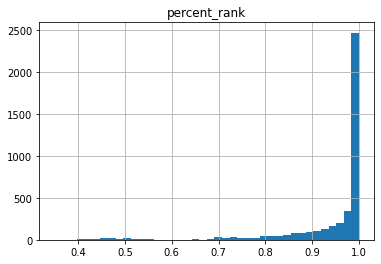

In [259]:
hero_rankings_df.hist(column='percent_rank', bins=40, range=[0.35, 1]) 

# Data Cleaning

In [260]:
games_df[games_df['match_id'] == 6509122417]

,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,account_id,hero_id,win


In [261]:
# filter out duplicate players
print("size players before duplicates:" + str (len(player_df.index)))
player_df = player_df.astype(str).drop_duplicates(subset='account_id') 
print("size after player duplicates:" + str (len(player_df.index)))


size players before duplicates:4061
size after player duplicates:971


In [262]:
# filter out duplicate players hero rankings
print("size players before duplicates:" + str (len(hero_rankings_df.index)))
hero_rankings_df = hero_rankings_df.astype(str).drop_duplicates(subset=['account_id', 'hero_id']) 
print("size after player duplicates:" + str (len(hero_rankings_df.index)))

size players before duplicates:4191
size after player duplicates:3094


In [263]:
hero_rankings_df.groupby(['account_id','hero_id']).count()

card  percent_rank  score
account_id hero_id                           
100058342  15          1             1      1
           19          1             1      1
           48          1             1      1
           49          1             1      1
           81          1             1      1
...                  ...           ...    ...
99796146   79          1             1      1
           90          1             1      1
99906163   120         1             1      1
           123         1             1      1
999066307  129         1             1      1

[3094 rows x 3 columns]

In [264]:
# delete unnecessary game_modes, we use captains mode in this case
games_df.drop(games_df[games_df.game_mode != 2].index, inplace=True)

In [265]:
#fill in missing data

def convert_estimated_mmr(row):
    print(row)
    return int(re.findall(r'\d+', row['mmr_estimate'])[0])

player_df['mmr_estimate'] = player_df.apply(convert_estimated_mmr, axis=1)


def convert_rank_tier(row):
    l = re.findall(r'\d+', row['rank_tier'])
    if len(l) == 0:
        return 0
    return int(l[0])

player_df['rank_tier'] = player_df.apply(convert_rank_tier, axis=1)
player_df.head(1)



account_id                       1284611820
competitive_rank                       None
leaderboard_rank                       None
mmr_estimate             {'estimate': 3723}
rank_tier                              None
solo_competitive_rank                  None
tracked_until                          None
Name: 0, dtype: object
account_id                        412320425
competitive_rank                       None
leaderboard_rank                       4370
mmr_estimate             {'estimate': 3913}
rank_tier                                80
solo_competitive_rank                  None
tracked_until                          None
Name: 1, dtype: object
account_id                        225617497
competitive_rank                       4324
leaderboard_rank                       2047
mmr_estimate             {'estimate': 3762}
rank_tier                                80
solo_competitive_rank                  3478
tracked_until                    1654960229
Name: 2, dtype: object
account

,account_id,competitive_rank,leaderboard_rank,mmr_estimate,rank_tier,solo_competitive_rank,tracked_until
0,1284611820,None,None,3723,0,None,None


In [266]:
player_df.groupby('rank_tier').count()

,account_id,competitive_rank,leaderboard_rank,mmr_estimate,solo_competitive_rank,tracked_until
rank_tier,,,,,,
0,80,80,80,80,80,80
15,2,2,2,2,2,2
25,2,2,2,2,2,2
31,1,1,1,1,1,1
33,1,1,1,1,1,1
34,1,1,1,1,1,1
41,1,1,1,1,1,1
43,3,3,3,3,3,3
45,2,2,2,2,2,2


In [267]:
# encode hero roles 
# Generate a dataframe of heroes with roles as dummy variables

def getHeroDF(hero):
    '''
    A function used to generate a dummy-value dataframe of heroes. Each row is a hero and each column is a role. 
    The 0-1 values in the dataframe indicates whether a hero (row) could play a role (column).
    
    INPUT:
    - hero: the hero dataframe
    
    OUTPUT:
    - hero_df: the dummy-value dataframe for heroes
    
    '''

    #hero = hero.set_index('id')

    hero_df = pd.DataFrame(hero['roles'].to_list())
#     hero_df['id'] = hero.index
#     hero_df = hero_df.set_index('id')
    #localized_name	primary_attr	attack_type	
    hero_df['primary_attr'] = hero['primary_attr']
    hero_df['attack_type'] = hero['attack_type']
    hero_df = pd.get_dummies(hero_df.stack()).groupby(level=0).sum()
    hero_df['localized_name'] = hero['localized_name']
 #   hero_df['hero_id'] = range(1, len(hero_df) + 1)
    hero_df['hero_id'] = hero['id']

    
    return hero_df

hero_df = getHeroDF(heroes_df)
hero_df.head(10)
#heroes_df.head()

,Carry,Disabler,Durable,Escape,Initiator,Jungler,Melee,Nuker,Pusher,Ranged,Support,agi,int,str,localized_name,hero_id
0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,Anti-Mage,1
1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,Axe,2
2,0,1,1,0,0,0,0,1,0,1,1,0,1,0,Bane,3
3,1,1,0,0,1,1,1,1,0,0,0,1,0,0,Bloodseeker,4
4,0,1,0,0,0,1,0,1,0,1,1,0,1,0,Crystal Maiden,5
5,1,1,0,0,0,0,0,0,1,1,0,1,0,0,Drow Ranger,6
6,0,1,0,0,1,0,1,1,0,0,1,0,0,1,Earthshaker,7
7,1,0,0,1,0,0,1,0,1,0,0,1,0,0,Juggernaut,8
8,1,1,0,1,0,0,0,1,0,1,1,1,0,0,Mirana,9
9,1,1,1,1,0,0,0,1,0,1,0,1,0,0,Morphling,10


In [268]:
games_df['avg_mmr'].isnull().values.any()


False

In [269]:
#Fix data types of columns
games_df['win'] = games_df['win'].astype(bool)


In [270]:
# combine heroes and match dataframes
games_and_heros = pd.merge(games_df, hero_df, on=['hero_id'], how='inner').sort_values(by=['match_id'])
#games_and_heros = games_and_heros.drop(columns = ['name', 'legs'])#.sort_values(by=['match_id'])
print(len(games_and_heros.index))
games_and_heros.head()

4180


,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,account_id,hero_id,win,Carry,Disabler,Durable,Escape,Initiator,Jungler,Melee,Nuker,Pusher,Ranged,Support,agi,int,str,localized_name
3282,6521088403,1649767607,4327,5,2,1,206599897,98,False,0,0,1,1,0,0,1,1,0,0,0,0,0,1,Timbersaw
522,6521088403,1649767607,4327,5,2,1,439674315,121,False,0,1,0,1,0,0,0,1,0,1,1,0,1,0,Grimstroke
666,6521088403,1649767607,4327,5,2,1,425928431,126,True,1,1,0,1,0,0,1,1,0,0,0,0,1,0,Void Spirit
1160,6521088403,1649767607,4327,5,2,1,280262730,91,True,0,0,0,1,0,0,0,1,0,1,1,0,0,1,Io
2797,6521088403,1649767607,4327,5,2,1,324367591,17,False,1,1,0,1,1,0,0,1,0,1,0,0,1,0,Storm Spirit


In [271]:
# combine heroes and match and players dataframes
games_and_heros['account_id'] = games_and_heros['account_id'].astype(int)
player_df['account_id'] = player_df['account_id'].astype(int)
# player_df['rank_tier'] = player_df['rank_tier'].astype(int)


games_and_heros_and_players = pd.merge(games_and_heros, player_df, on=['account_id'], how='inner').sort_values(by=['match_id'])
print(len(games_and_heros_and_players.index))
games_and_heros_and_players.head(5)

4180


,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,account_id,hero_id,win,Carry,Disabler,Durable,Escape,Initiator,Jungler,Melee,Nuker,Pusher,Ranged,Support,agi,int,str,localized_name,competitive_rank,leaderboard_rank,mmr_estimate,rank_tier,solo_competitive_rank,tracked_until
0,6521088403,1649767607,4327,5,2,1,206599897,98,False,0,0,1,1,0,0,1,1,0,0,0,0,0,1,Timbersaw,3191,4090,3798,75,3015,None
8,6521088403,1649767607,4327,5,2,1,219006194,70,True,1,1,1,0,0,1,1,0,0,0,0,1,0,0,Ursa,3919,None,3939,74,4018,None
7,6521088403,1649767607,4327,5,2,1,1004528339,81,False,1,1,1,0,1,0,1,0,1,0,0,0,0,1,Chaos Knight,None,4185,2964,64,None,None
6,6521088403,1649767607,4327,5,2,1,178002197,129,True,1,1,1,0,1,0,1,0,0,0,0,0,0,1,Mars,4621,1909,4304,80,5151,None
5,6521088403,1649767607,4327,5,2,1,127533364,3,True,0,1,1,0,0,0,0,1,0,1,1,0,1,0,Bane,None,None,4319,74,4747,None


In [272]:
hero_rankings_df['account_id'] =  hero_rankings_df['account_id'].astype(int)
games_and_heros_and_players['account_id'] =  games_and_heros_and_players['account_id'].astype(int)

hero_rankings_df['hero_id'] =  hero_rankings_df['hero_id'].astype(int)
games_and_heros_and_players['hero_id'] =  games_and_heros_and_players['hero_id'].astype(int)
# hero_rankings_df =  hero_rankings_df.drop('hero_id', 1)


games_and_heros_and_players_and_rankings = pd.merge(hero_rankings_df, games_and_heros_and_players, on=['account_id', 'hero_id'], how='inner').sort_values(by=['match_id'])


In [273]:
games_and_heros_and_players_and_rankings.head(5)

,account_id,card,hero_id,percent_rank,score,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,win,Carry,Disabler,Durable,Escape,Initiator,Jungler,Melee,Nuker,Pusher,Ranged,Support,agi,int,str,localized_name,competitive_rank,leaderboard_rank,mmr_estimate,rank_tier,solo_competitive_rank,tracked_until
4179,178002197,3204000,129,0.85143570536829,4299.32052950125,6521088403,1649767607,4327,5,2,1,True,1,1,1,0,1,0,1,0,0,0,0,0,0,1,Mars,4621,1909,4304,80,5151,None
4177,127533364,3436000,3,0.854481955762515,4199.84916045362,6521088403,1649767607,4327,5,2,1,True,0,1,1,0,0,0,0,1,0,1,1,0,1,0,Bane,None,None,4319,74,4747,None
4176,425928431,2116000,126,0.994328922495274,7199.31514816971,6521088403,1649767607,4327,5,2,1,True,1,1,0,1,0,0,1,1,0,0,0,0,1,0,Void Spirit,None,4040,4346,74,None,None
4175,219006194,3948000,70,0.997973657548126,6828.71402055645,6521088403,1649767607,4327,5,2,1,True,1,1,1,0,0,1,1,0,0,0,0,1,0,0,Ursa,3919,None,3939,74,4018,None
4174,340169816,3976000,31,0.868209255533199,4368.92961282202,6521088403,1649767607,4327,5,2,1,False,0,0,0,0,0,0,0,1,0,1,1,0,1,0,Lich,None,None,3683,61,None,None


In [274]:
print(len(games_and_heros_and_players_and_rankings.index))

4180


In [275]:
# # delete unnecessary game_modes, we use captains mode in this case
# games_and_heros_and_players.drop(games_and_heros_and_players[games_and_heros_and_players.game_mode != 2].index, inplace=True)

#drop games where rank is under 70:
# games_and_heros_and_players.drop(games_and_heros_and_players[games_and_heros_and_players.rank_tier < 70].index, inplace=True)

# games_and_heros_and_players.groupby('rank_tier').count()

In [276]:
list(games_and_heros_and_players_and_rankings)

['account_id',
 'card',
 'hero_id',
 'percent_rank',
 'score',
 'match_id',
 'start_time',
 'avg_mmr',
 'num_mmr',
 'game_mode',
 'lobby_type',
 'win',
 'Carry',
 'Disabler',
 'Durable',
 'Escape',
 'Initiator',
 'Jungler',
 'Melee',
 'Nuker',
 'Pusher',
 'Ranged',
 'Support',
 'agi',
 'int',
 'str',
 'localized_name',
 'competitive_rank',
 'leaderboard_rank',
 'mmr_estimate',
 'rank_tier',
 'solo_competitive_rank',
 'tracked_until']

In [277]:
games_and_heros_and_players_and_rankings.dtypes

account_id                int32
card                     object
hero_id                   int32
percent_rank             object
score                    object
match_id                  int64
start_time                int64
avg_mmr                  object
num_mmr                  object
game_mode                 int64
lobby_type                int64
win                        bool
Carry                     uint8
Disabler                  uint8
Durable                   uint8
Escape                    uint8
Initiator                 uint8
Jungler                   uint8
Melee                     uint8
Nuker                     uint8
Pusher                    uint8
Ranged                    uint8
Support                   uint8
agi                       uint8
int                       uint8
str                       uint8
localized_name           object
competitive_rank         object
leaderboard_rank         object
mmr_estimate              int64
rank_tier                 int64
solo_com

In [278]:
#Number of wins and losses should be even
games_and_heros_and_players_and_rankings.groupby('rank_tier').count()

,account_id,card,hero_id,percent_rank,score,match_id,start_time,avg_mmr,num_mmr,game_mode,lobby_type,win,Carry,Disabler,Durable,Escape,Initiator,Jungler,Melee,Nuker,Pusher,Ranged,Support,agi,int,str,localized_name,competitive_rank,leaderboard_rank,mmr_estimate,solo_competitive_rank,tracked_until
rank_tier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827
15,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
25,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
31,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
33,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
34,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
41,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
43,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
45,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


In [279]:
# teams dataFrame
def average(x):
    for i in x:
        print(str(float(i)))
        
    return 'l'#(sum(x) / len(x))

obj = games_and_heros_and_players_and_rankings.groupby(['match_id', 'win'])

def rank_tier_average(x):
    sum = 0;
    c = 0
    for i in x:
        if i == 0:
            pass
        else:
            sum += i
            c += 1
    if c == 0:
        #these are dropped later
        return 100
    else: 
        return sum/c

def average(x):
    sum = 0;
    c = 0
    for i in x:
        v = float(i)
        if v == 0:
            pass
        else:
            sum += v
            c += 1
    if c == 0:
        print("100")
        return 100
    else: 
         return sum/c


teams_df = obj.agg(
    team_win=pd.NamedAgg(column="win", aggfunc="first"),
    match_id=pd.NamedAgg(column="match_id", aggfunc="first"),
    start_time=pd.NamedAgg(column="start_time", aggfunc="first"),
    hero_id=pd.NamedAgg(column="hero_id", aggfunc="unique"),
    match_mmr_average=pd.NamedAgg(column="avg_mmr", aggfunc="first"),
    team_mmr_estimate=pd.NamedAgg(column="mmr_estimate", aggfunc="mean"),
    rank_tier_unique_values=pd.NamedAgg(column="rank_tier", aggfunc="unique"),
    rank_tier_average=pd.NamedAgg("rank_tier", lambda x : rank_tier_average(x)),
    game_mode=pd.NamedAgg(column="game_mode", aggfunc="first"),
    score_avg=pd.NamedAgg("score", lambda x : average(x)),
    percent_rank_avg=pd.NamedAgg("percent_rank", lambda x : average(x)),
    game_avg_mmr=pd.NamedAgg(column="avg_mmr", aggfunc="first"),
    
    
    #    geomean_of_hue = pd.NamedAgg('hue', lambda x: x.prod() ** (1 / len(x)))

    
    #roles
    Carry_count=pd.NamedAgg(column="Carry", aggfunc="sum"),
    Support_count=pd.NamedAgg(column="Support", aggfunc="sum"),
    Durable_count=pd.NamedAgg(column="Durable", aggfunc="sum"),
    Disabler_count=pd.NamedAgg(column="Disabler", aggfunc="sum"),
    Escape_count=pd.NamedAgg(column="Escape", aggfunc="sum"),
    Initiator_count=pd.NamedAgg(column="Initiator", aggfunc="sum"),
    Jungler_count=pd.NamedAgg(column="Jungler", aggfunc="sum"),
    Nuker_count=pd.NamedAgg(column="Nuker", aggfunc="sum"),
    Pusher_count=pd.NamedAgg(column="Pusher", aggfunc="sum"),
    #attribute
    agi_count=pd.NamedAgg(column="agi", aggfunc="sum"),
    int_count=pd.NamedAgg(column="int", aggfunc="sum"),
    str_count=pd.NamedAgg(column="str", aggfunc="sum"),
    #range/melee
    Melee_count=pd.NamedAgg(column="Melee", aggfunc="sum"),
    Ranged_count=pd.NamedAgg(column="Ranged", aggfunc="sum"),
)
teams_df['mmr_difference'] = 0.5
teams_df['rank_tier_difference'] = 0.5

# dropping teams with no rank tier among them,

# teams_df = teams_df[teams_df.rank_tier_average != 100]

pd.set_option('display.max_columns', None)
teams_df.head()

team_win    match_id  start_time                hero_id  \
match_id   win                                                              
6521088403 False     False  6521088403  1649767607  [31, 121, 98, 17, 81]   
           True       True  6521088403  1649767607  [129, 3, 126, 70, 91]   
6521174117 False     False  6521174117  1649769272   [85, 114, 59, 7, 86]   
           True       True  6521174117  1649769272  [49, 101, 81, 74, 91]   
6521218103 False     False  6521218103  1649771268  [86, 121, 77, 61, 46]   

                 match_mmr_average  team_mmr_estimate rank_tier_unique_values  \
match_id   win                                                                  
6521088403 False              4327        3317.600000     [61, 54, 75, 0, 64]   
           True               4327        4297.000000                [80, 74]   
6521174117 False              3253        3292.400000                 [80, 0]   
           True               3253        3808.500000             [0, 75, 80]   
6521218103 False              5827        6112.833333                    [80]   

                  rank_tier_average  game_mode    score_avg  percent_rank_avg  \
match_id   win                                                                  
6521088403 False               63.5          2  4552.410151          0.864652   
           True                76.4          2  5524.494270          0.935509   
6521174117 False               80.0          2  5522.931977          0.928278   
           True                77.5          2  6196.630053          0.979762   
6521218103 False               80.0          2  8089.941875          0.999732   

                 game_avg_mmr  Carry_count  Support_count  Durable_count  \
match_id   win                                                             
6521088403 False         4327            2              2              2   
           True          4327            3              2              3   
6521174117 False         3253            2              3              2   
           True          3253            4              2              3   
6521218103 False         5827            3              3              1   

                  Disabler_count  Escape_count  Initiator_count  \
match_id   win                                                    
6521088403 False               3             3                2   
           True                4             2                1   
6521174117 False               4             1                3   
           True                5             2                3   
6521218103 False               3             4                0   

                  Jungler_count  Nuker_count  Pusher_count  agi_count  \
match_id   win                                                          
6521088403 False              0            4             1          0   
           True               1            3             0          1   
6521174117 False              0            3             0          1   
           True               0            4             4          0   
6521218103 False              1            4             2          2   

                  int_count  str_count  Melee_count  Ranged_count  \
match_id   win                                                      
6521088403 False          3          2            2             3   
           True           2          2            3             2   
6521174117 False          1          3            3             2   
           True           2          4            3             3   
6521218103 False          3          1            2             4   

                  mmr_difference  rank_tier_difference  
match_id   win                                          
6521088403 False             0.5                   0.5  
           True              0.5                   0.5  
6521174117 False             0.5                   0.5  
           True              0.5                   0.5  
6

In [280]:
def set_normalized_mmr_difference(row):
    myResult = row['team_win']
    game_id = row['match_id']
    my_mmr_estimate = row['team_mmr_estimate'] 
    opponent_team_mmr_estimate = teams_df.loc[game_id].loc[not myResult]['team_mmr_estimate']
    total = my_mmr_estimate + opponent_team_mmr_estimate
    return my_mmr_estimate / total
    
teams_df['mmr_difference'] = teams_df.apply(lambda row: set_normalized_mmr_difference(row), axis=1) 

def set_normalized_rank_tier(row):
    myResult = row['team_win']
    game_id = row['match_id']
    my_rank_estimate = row['rank_tier_average'] 
    opponent_team_rank_estimate = teams_df.loc[game_id].loc[not myResult]['rank_tier_average']
    
    #some teams have no rank tier estimate
    if opponent_team_rank_estimate == 100 or my_rank_estimate == 100:
        return 0.5
    
    total = my_rank_estimate + opponent_team_rank_estimate
    return my_rank_estimate / total
    

#teams_df['mmr_difference'] = teams_df.apply(lambda row: set_normalized_mmr_difference(row), axis=1) 
teams_df['rank_tier_difference'] = teams_df.apply(lambda row: set_normalized_rank_tier(row), axis=1) 
#df['add'] = df.apply(lambda row : add(row['A'],
#                      row['B'], row['C']), axis = 1)

In [281]:
#for match_id in teams_df['match_id'].unique()
#teams_df.loc[6413678308].loc[False]['hero_id'] = 9

teams_df.head(1)

,,team_win,match_id,start_time,hero_id,match_mmr_average,team_mmr_estimate,rank_tier_unique_values,rank_tier_average,game_mode,score_avg,percent_rank_avg,game_avg_mmr,Carry_count,Support_count,Durable_count,Disabler_count,Escape_count,Initiator_count,Jungler_count,Nuker_count,Pusher_count,agi_count,int_count,str_count,Melee_count,Ranged_count,mmr_difference,rank_tier_difference
match_id,win,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6521088403,False,False,6521088403,1649767607,"[31, 121, 98, 17, 81]",4327,3317.6,"[61, 54, 75, 0, 64]",63.5,2,4552.410151,0.864652,4327,2,2,2,3,3,2,0,4,1,0,3,2,2,3,0.435689,0.453896


# Data Analysis

array([[<AxesSubplot:title={'center':'team_mmr_estimate'}>]], dtype=object)

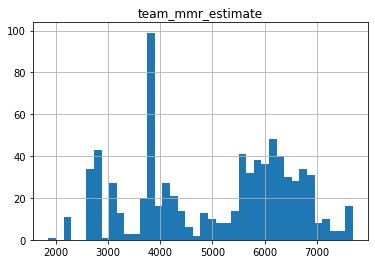

In [282]:
# corr = games_and_heros.corr()
# # corr.style.background_gradient(cmap='coolwarm')
# corr

teams_df.hist(column='team_mmr_estimate', bins=40) 
#plt.plot(teams_df['team_mmr_estimate'].to_list())

array([[<AxesSubplot:title={'center':'mmr_difference'}>]], dtype=object)

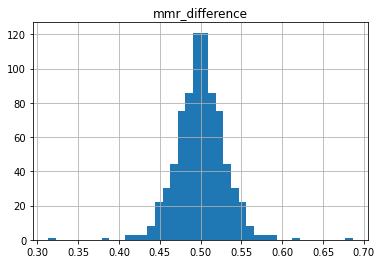

In [283]:
teams_df.hist(column='mmr_difference', bins=40) 

array([[<AxesSubplot:title={'center':'rank_tier_difference'}>]],
      dtype=object)

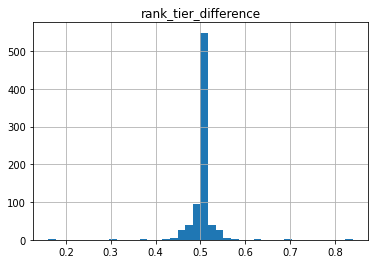

In [284]:
teams_df.hist(column='rank_tier_difference', bins=40) 

In [285]:
#player_df.hist(column='rank_tier')

In [286]:
# corr = games_and_heros['win'].corr(games_and_heros['attack_type'])
# games_and_heros['attack_type'].value_counts(normalize=True) * 100

In [287]:
def selection_size_to_percentage(s, dataframe):
     return (s / len(dataframe.index)) * 100

    
# conditions = [
#     (teams_df['Carry_count'] < 4), 
#     True, #(teams_df['mmr_difference'] >= 0.5), 
#     True,#(teams_df['rank_tier_difference'] >= 0.54), 
#     True, #(teams_df['Support_count'] >= 3)
# ]
# conditions = [
#     (teams_df['agi_count'] != 0),
#     (teams_df['str_count'] != 0),
#     (teams_df['int_count'] != 0),
#     True,
# ]

# conditions = [
#     (teams_df['Melee_count'] < 4), 
#     (teams_df['Ranged_count'] < 4), #(teams_df['mmr_difference'] >= 0.5), 
#     True,#(teams_df['rank_tier_difference'] >= 0.54), 
#     True, #(teams_df['Support_count'] >= 3)
# ]

conditions = [
    (teams_df['Durable_count'] + teams_df['Disabler_count'] + teams_df['Escape_count'] + teams_df['Initiator_count'] + teams_df['Jungler_count'] + teams_df['Pusher_count'] > 12), 
    True, #(teams_df['mmr_difference'] >= 0.5), 
    True,#(teams_df['rank_tier_difference'] >= 0.54), 
    True, #(teams_df['Support_count'] >= 3)
]

# conditions = [
#     (teams_df['Durable_count'] + teams_df['Disabler_count'] + teams_df['Escape_count'] + teams_df['Initiator_count'] + teams_df['Jungler_count'] + teams_df['Pusher_count'] > 12), 
#     (teams_df['Carry_count'] < 4),
#     True, 
#     True, 
# ]

# conditions = [
#     (teams_df['Durable_count'] + teams_df['Disabler_count'] + teams_df['Escape_count'] + teams_df['Initiator_count'] + teams_df['Jungler_count'] + teams_df['Pusher_count'] > 12), 
#     (teams_df['Carry_count'] < 4),
#     (teams_df['agi_count'] != 0) & (teams_df['str_count'] != 0) & (teams_df['int_count'] != 0), 
#     (teams_df['Melee_count'] < 4) & (teams_df['Ranged_count'] < 4), 
 
# ]

win = selection_size_to_percentage(len(teams_df[
                                        conditions[0] &
                                        conditions[1] &
                                        conditions[2] &
                                        conditions[3] &
                                        (teams_df['team_win'] == True)].index), teams_df)

loss = selection_size_to_percentage(len(teams_df[
                                        conditions[0] &
                                        conditions[1] &
                                        conditions[2] &
                                        conditions[3] &
                                        (teams_df['team_win'] == False)].index), teams_df)


game_count = selection_size_to_percentage(len(teams_df[
                        conditions[0] &
                        conditions[1] &
                        conditions[2] &
                        conditions[3] 
                     ].index), teams_df)


print('win %: ' + str(win))
print('loss %: ' + str(loss))

print('difference (win-loss)%: ' + str(win - loss))
print('percentage of games wher this condition(treatment) applies: ' + str(game_count))


# def apply_treatment(row):
#     if row['Carry_count'] < 4:
#         return 1
#     else: 
#         return 0

# def apply_treatment(row):
#     if row['agi_count'] != 0 & (row['str_count'] != 0) & (row['int_count'] != 0):
#         return 1
#     else: 
#         return 0


# def apply_treatment(row):
#     if (row['Melee_count'] < 4) & (row['Ranged_count'] < 4):
#         return 1
#     else: 
#         return 0

def apply_treatment(row):
    if  (row['Durable_count'] + row['Disabler_count'] + row['Escape_count'] + row['Initiator_count'] + row['Jungler_count'] + row['Pusher_count'] > 12):
        return 1
    else: 
        return 0
        

# def apply_treatment(row):
#     if  (row['Durable_count'] + row['Disabler_count'] + row['Escape_count'] + row['Initiator_count'] + row['Jungler_count'] + row['Pusher_count'] > 12) & (row['Carry_count'] < 4):
#         return 1
#     else: 
#         return 0

# def apply_treatment(row):
#     if  (row['Durable_count'] + row['Disabler_count'] + row['Escape_count'] + row['Initiator_count'] + row['Jungler_count'] + row['Pusher_count'] > 12) & (row['Carry_count'] < 4) & (row['agi_count'] != 0) & (row['str_count'] != 0) & (row['int_count'] != 0) & (row['Melee_count'] < 4) & (row['Ranged_count'] < 4):
#         return 1
#     else: 
#         return 0


def apply_confounder_rank_tier(row): 
    if row['rank_tier_difference'] >= 0.5:
        return 1
    else:
        return 0 

teams_df['condition'] = teams_df.apply(lambda row: apply_treatment(row), axis=1) 
teams_df['confounder_rank_tier'] = teams_df.apply(lambda row: apply_confounder_rank_tier(row), axis=1)

# teams_df["condition"] = teams_df[
#                                     conditions[0] &
#                                     conditions[1] &
#                                     conditions[2] &
#                                     conditions[3]
#                                 ]

win %: 28.463476070528966
loss %: 26.070528967254408
difference (win-loss)%: 2.392947103274558
percentage of games wher this condition(treatment) applies: 54.53400503778337


In [288]:
teams_df.head(1)

,,team_win,match_id,start_time,hero_id,match_mmr_average,team_mmr_estimate,rank_tier_unique_values,rank_tier_average,game_mode,score_avg,percent_rank_avg,game_avg_mmr,Carry_count,Support_count,Durable_count,Disabler_count,Escape_count,Initiator_count,Jungler_count,Nuker_count,Pusher_count,agi_count,int_count,str_count,Melee_count,Ranged_count,mmr_difference,rank_tier_difference,condition,confounder_rank_tier
match_id,win,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6521088403,False,False,6521088403,1649767607,"[31, 121, 98, 17, 81]",4327,3317.6,"[61, 54, 75, 0, 64]",63.5,2,4552.410151,0.864652,4327,2,2,2,3,3,2,0,4,1,0,3,2,2,3,0.435689,0.453896,0,0


In [289]:
# player_df.groupby('rank_tier').count()

array([[<AxesSubplot:title={'center':'rank_tier_difference'}>]],
      dtype=object)

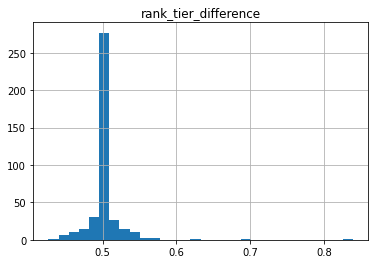

In [290]:
teams_df[(teams_df['team_win'] == True)].hist(column='rank_tier_difference', bins=30) 

array([[<AxesSubplot:title={'center':'percent_rank_avg'}>]], dtype=object)

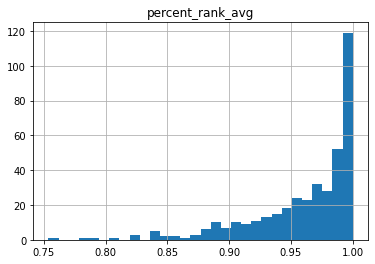

In [291]:
teams_df[(teams_df['team_win'] == True)].hist(column='percent_rank_avg', bins=30) 

In [292]:
# do i drop matches where there is no competitive rank?


# Simple IPW on discrete treatment and discrete confounder

In [293]:
teams_df.groupby('game_mode').count()

,team_win,match_id,start_time,hero_id,match_mmr_average,team_mmr_estimate,rank_tier_unique_values,rank_tier_average,score_avg,percent_rank_avg,game_avg_mmr,Carry_count,Support_count,Durable_count,Disabler_count,Escape_count,Initiator_count,Jungler_count,Nuker_count,Pusher_count,agi_count,int_count,str_count,Melee_count,Ranged_count,mmr_difference,rank_tier_difference,condition,confounder_rank_tier
game_mode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794,794


In [294]:
teams_df.groupby('win').count()

,team_win,match_id,start_time,hero_id,match_mmr_average,team_mmr_estimate,rank_tier_unique_values,rank_tier_average,game_mode,score_avg,percent_rank_avg,game_avg_mmr,Carry_count,Support_count,Durable_count,Disabler_count,Escape_count,Initiator_count,Jungler_count,Nuker_count,Pusher_count,agi_count,int_count,str_count,Melee_count,Ranged_count,mmr_difference,rank_tier_difference,condition,confounder_rank_tier
win,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397
True,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397


In [295]:
# # create pseudo population
# total = len(teams_df.index)
# treated = len(teams_df[(teams_df['condition'] == 1)].index)
# non_treated = len(teams_df[(teams_df['condition'] == 0)].index)
# psuedo_pop_df = teams_df
# psuedo_pop_df['confounder'] = teams_df['confounder_rank_tier']
# psuedo_pop_df['treatment'] = teams_df['condition']

# psuedo_pop_df = psuedo_pop_df.loc[:, psuedo_pop_df.columns.intersection(['confounder_rank_tier','treatment', 'team_win'])]
# psuedo_pop_df.head()


In [296]:
# def convert_estimated_mmr(row):
#     print(row)
#     return int(re.findall(r'\d+', row['mmr_estimate'])[0])

# player_df['mmr_estimate'] = player_df.apply(convert_estimated_mmr, axis=1)

# who gets the treatmen 

# 43 + 34
# 121 + 130

# len(psuedo_pop_df[(psuedo_pop_df['treatment'] == 0) &  (psuedo_pop_df['confounder_rank_tier'] == 1)].index)

In [297]:
# amount of teams
str(len(teams_df.index))

'794'

In [298]:
# wins / teams
print(
    str(len(teams_df[(teams_df['condition'] == 1) &  (teams_df['confounder_rank_tier'] == 0)].index)) + 
    ' / ' + 
    str(len(teams_df.index))
    )                                 

95 / 794


In [299]:
## advantage / Yes
print(
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 1) & (teams_df['condition'] == 1) & (teams_df['team_win'] == 1)].index)) + 
    ' / ' + 
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 1) & (teams_df['condition'] == 1) ].index))
    )                                 

181 / 338


In [300]:
## advantage / No
print(
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 1) & (teams_df['condition'] == 0) & (teams_df['team_win'] == 1)].index)) + 
    ' / ' + 
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 1) & (teams_df['condition'] == 0) ].index))
    )                                 

144 / 286


In [301]:
## dis-advantage / Yes
print(
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 0) & (teams_df['condition'] == 1) & (teams_df['team_win'] == 1)].index)) + 
    ' / ' + 
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 0) & (teams_df['condition'] == 1) ].index))
    )                                 

45 / 95


In [302]:
## dis-advantage / No
print(
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 0) & (teams_df['condition'] == 0) & (teams_df['team_win'] == 1)].index)) + 
    ' / ' + 
    str(len(teams_df[(teams_df['confounder_rank_tier'] == 0) & (teams_df['condition'] == 0) ].index))
    )                                 

27 / 75


### Test calculation by hand

- Treatment in this case is  carry_count >= 4 

- 328 teams

| Rank-advantage\Treatment | Yes (1)  | No (0) |
| --- |---|---|
| Combined |33 / 77 | 132 / 251 |
| rank-advantage | 21 / 43  | 77 / 121  |
| rank-disadvantage |  11 / 34 |  55 / 130 |

probability of Treatment, given rank advantage: 43 / (43 + 121) = 0.26 given rank dis-advantage: 34 / (34 + 130) = 0.2 

probability of no-Treatment, given rank advantage: 121 / (43 + 121) = 0.73 given rank dis-advantage: 130 / (34 + 130) = 0.8 

(since we look only at binary rank advantage, the teams are basically identical within their groups, so we can use group-level weights)

Calculating IP-weighted average: $ (1/Pr[T|C] ) ·Pr[W|T,C] $

#### Correcting for confounder:


change of winning for Treatment = $ ( ( ( 43/(43 + 121) ) ^ {(-1)} * (21/43) ) + ((34 / (34 + 130)) ^ {-1} * (11/34)) ) / ((( 43 / (43 + 121) ) ^ {(-1)}) + ((34 / (34 + 130)) ^ {-1})) = $ 39.6%

with correction for confounder: 39.6%

without correction for confounder: 41.6%

-------------

change of winning for no-Treatment = $ ( ( ( 121 / (43 + 121) ) ^ {(-1)} * (77/121) ) + ((130 / (34 + 130)) ^ {-1} * (55/130)) ) / ((( 121 / (43 + 121) ) ^ {(-1)}) + ((130 / (34 + 130))) ^ {-1}) = $ 53,3%

with correction for confounder: 53.3%

without correction for confounder: 52.58%

In [303]:
# chance of winning given treatment without correction for confounder: 
len(teams_df[(teams_df['team_win'] == 1) & (teams_df['condition'] == 1) ].index) / len(teams_df[(teams_df['condition'] == 1)])

0.5219399538106235

In [304]:
# chance of winning given no treatment without correction for confounder: 
len(teams_df[(teams_df['team_win'] == 1) & (teams_df['condition'] == 0) ].index) / len(teams_df[(teams_df['condition'] == 0)])

0.47368421052631576

# Rank_tier regression model + IPW on single confounder

we want to estimate Pr[ A=1 | Confounders]

In [305]:
# g = gr.Digraph()
# g.edge("Z", "X")
# g.edge("U", "X")
# g.edge("U", "Y")

# g.edge("medicine", "survived")
# g.edge("severeness", "survived")
# g.edge("severeness", "medicine")

# g

In [306]:
rank_tier_condition = teams_df[['rank_tier_difference', 'condition', 'team_win']]
rank_tier_condition['condition'] = rank_tier_condition['condition'].astype(int)
rank_tier_condition['team_win'] = rank_tier_condition['team_win'].astype(int)
rank_tier_condition.head()

C:\Users\Christof\AppData\Local\Temp\ipykernel_6752\202720262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_tier_condition['condition'] = rank_tier_condition['condition'].astype(int)
C:\Users\Christof\AppData\Local\Temp\ipykernel_6752\202720262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_tier_condition['team_win'] = rank_tier_condition['team_win'].astype(int)


rank_tier_difference  condition  team_win
match_id   win                                             
6521088403 False              0.453896          0         0
           True               0.546104          0         1
6521174117 False              0.507937          0         0
           True               0.492063          1         1
6521218103 False              0.500000          0         0

In [307]:
x = rank_tier_condition['rank_tier_difference'].to_numpy().reshape(-1,1)
y = rank_tier_condition['condition'].to_numpy()
win = rank_tier_condition['team_win'].to_numpy()
y

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,

In [308]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=40)

In [309]:
# logistic regressions tier-ranking

clf = LogisticRegression(random_state=0).fit(x, y)

#class_weight = 'balanced'

In [310]:
clf.predict([[0.3]])

array([1])

In [311]:
accuracy_score(y_true=y, y_pred=clf.predict(x))

0.5453400503778337

In [312]:
# probability of treatment and no treatmnent
resArray = clf.predict_proba(x)

resArray[:20]

array([[0.44992091, 0.55007909],
       [0.45940512, 0.54059488],
       [0.45547537, 0.54452463],
       [0.45384268, 0.54615732],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ],
       [0.45427716, 0.54572284],
       [0.4550407 , 0.5449593 ],
       [0.4546589 , 0.5453411 ],
       [0.4546589 , 0.5453411 ]])

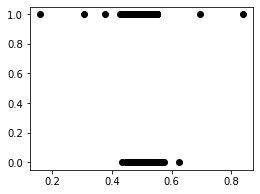

In [313]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(x.ravel(), y, color="black", zorder=20)
plt.show()

In [314]:
combined = np.column_stack((resArray, y, x))
combined[:5]

#combined = np.array(combined,)
# prob of no treatment, prob of treatment, test_class_values, confounder (s)


array([[0.44992091, 0.55007909, 0.        , 0.45389564],
       [0.45940512, 0.54059488, 0.        , 0.54610436],
       [0.45547537, 0.54452463, 0.        , 0.50793651],
       [0.45384268, 0.54615732, 1.        , 0.49206349],
       [0.4546589 , 0.5453411 , 0.        , 0.5       ]])

In [315]:
weigthed_combined = np.zeros((len(combined), 2))
#dtype=[('weight', float), ('treatment', int)]
i = 0
for row in combined:
    if np.isclose(row[2], 0):
        #print('0')
        weight =  row[0]**(-1)
        #print(weight)
        weigthed_combined[i] = [weight, row[2]] 
    else:
        #print('1')
        weight =  row[1]**(-1)
        #print(weight)
        weigthed_combined[i] = [weight, row[2]] 
    
    i += 1

weigthed_combined_with_win = np.column_stack((weigthed_combined, win))
weigthed_combined_with_win[:10]
#list[:5]

array([[2.22261286, 0.        , 0.        ],
       [2.17672802, 0.        , 1.        ],
       [2.19550842, 0.        , 0.        ],
       [1.83097429, 1.        , 1.        ],
       [2.19945104, 0.        , 0.        ],
       [1.83371473, 1.        , 1.        ],
       [1.83371473, 1.        , 0.        ],
       [2.19945104, 0.        , 1.        ],
       [1.83371473, 1.        , 0.        ],
       [2.19945104, 0.        , 1.        ]])

In [316]:
df_results_weigths = pd.DataFrame(data=weigthed_combined_with_win[0:,0:], 
                 index= [i for i in range(weigthed_combined_with_win.shape[0])],
                 columns=['inverse_p_weight', 'treatment', 'win'])

df_results_weigths['treatment'] = df_results_weigths['treatment'].astype(int)
df_results_weigths['win'] = df_results_weigths['win'].astype(int)

In [317]:
df_results_weigths.head(5)

,inverse_p_weight,treatment,win
0,2.222613,0,0
1,2.176728,0,1
2,2.195508,0,0
3,1.830974,1,1
4,2.199451,0,0


In [318]:
len(df_results_weigths.index)

794

In [319]:
print('Ip-Weighted average: \n')


selection = 0
treatmentTotal = 0 
for i,  row in df_results_weigths.iterrows():
    if (row['treatment'] == 1) & (row['win'] == 1):
        selection += row['inverse_p_weight']
    if row['treatment'] == 1:
        treatmentTotal +=  row['inverse_p_weight']
    
print('In teams with the treatment: the change of you winning is: ') 
print (str(selection / treatmentTotal))


noTreatmentWin = 0
noTreatmentTotal = 0 
for i,  row in df_results_weigths.iterrows():
    if (row['treatment'] == 0) & (row['win'] == 1):
        noTreatmentWin += row['inverse_p_weight']
    if row['treatment'] == 0:
        noTreatmentTotal +=  row['inverse_p_weight']

print('In teams with NO treatment: the change of you winning is: ') 
print (str(noTreatmentWin / noTreatmentTotal))


Ip-Weighted average: 

In teams with the treatment: the change of you winning is: 
0.5222403104510808
In teams with NO treatment: the change of you winning is: 
0.47350990190179837


In [320]:
print("Original population size:  " +  str(len(df_results_weigths.index)))

print("Psuedo population size:  " +  str(df_results_weigths['inverse_p_weight'].sum()))

print("The Psuedo population should be doube the size of the original population")



Original population size:  794
Psuedo population size:  1587.6464090961204
The Psuedo population should be doube the size of the original population


# IPW multiple confoudnders - logistic regression 

estiamte probability of Treatment given confounders


In [321]:
var_selection = teams_df[['score_avg', 'percent_rank_avg', 'rank_tier_difference', 'mmr_difference', 'condition', 'team_win']]
var_selection['condition'] = var_selection['condition'].astype(int)
var_selection['team_win'] = var_selection['team_win'].astype(int)
var_selection['score_avg'] = var_selection['score_avg'].astype(float)
var_selection['percent_rank_avg'] = var_selection['percent_rank_avg'].astype(float)
var_selection['rank_tier_difference'] = var_selection['rank_tier_difference'].astype(float)
var_selection['mmr_difference'] = var_selection['mmr_difference'].astype(float)

var_selection.head()


C:\Users\Christof\AppData\Local\Temp\ipykernel_6752\583032441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_selection['condition'] = var_selection['condition'].astype(int)
C:\Users\Christof\AppData\Local\Temp\ipykernel_6752\583032441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_selection['team_win'] = var_selection['team_win'].astype(int)
C:\Users\Christof\AppData\Local\Temp\ipykernel_6752\583032441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

score_avg  percent_rank_avg  rank_tier_difference  \
match_id   win                                                          
6521088403 False  4552.410151          0.864652              0.453896   
           True   5524.494270          0.935509              0.546104   
6521174117 False  5522.931977          0.928278              0.507937   
           True   6196.630053          0.979762              0.492063   
6521218103 False  8089.941875          0.999732              0.500000   

                  mmr_difference  condition  team_win  
match_id   win                                         
6521088403 False        0.435689          0         0  
           True         0.564311          0         1  
6521174117 False        0.463660          0         0  
           True         0.536340          1         1  
6521218103 False        0.502393          0         0

In [322]:
# bootstrapping

bootstrap_var_dfs = []

for i in range(1000):
    bootstrap_var_dfs.append(var_selection.sample(var_selection.shape[0], replace=True))


In [323]:
# bootstrap_var_dfs[3]

In [324]:
# x = var_selection[['rank_tier_difference', 'percent_rank_avg', 'score_avg', 'mmr_difference']].to_numpy()
x = var_selection[[ 'score_avg', 'mmr_difference']].to_numpy()
y = var_selection['condition'].to_numpy()
win = var_selection['team_win'].to_numpy()
x[:10]

array([[4.55241015e+03, 4.35689334e-01],
       [5.52449427e+03, 5.64310666e-01],
       [5.52293198e+03, 4.63659536e-01],
       [6.19663005e+03, 5.36340464e-01],
       [8.08994188e+03, 5.02393000e-01],
       [6.23348122e+03, 4.97607000e-01],
       [5.95444194e+03, 4.66780978e-01],
       [8.00875019e+03, 5.33219022e-01],
       [7.29056148e+03, 4.82456368e-01],
       [6.66038568e+03, 5.17543632e-01]])

In [325]:
#ro predict probability of treatment given confounders
model = LogisticRegression(random_state=0, solver='liblinear').fit(x, y)


In [326]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [327]:
# bootstrap logistic models

bootstrap_logistic_output = []

for b_var_selection in bootstrap_var_dfs:
    b_x = b_var_selection[['score_avg', 'mmr_difference']].to_numpy()
    b_y = b_var_selection['condition'].to_numpy()
    b_win = b_var_selection['team_win'].to_numpy()

    b_model = LogisticRegression(random_state=0, solver='liblinear').fit(b_x, b_y)

    b_probOfTreatmentArray = b_model.predict_proba(b_x)

    b_combined = np.column_stack((b_probOfTreatmentArray, b_y, b_x))


    b_weigthed_combined = np.zeros((len(b_combined), 2))
    b_i = 0
    for row in b_combined:
        if np.isclose(row[2], 0):
            #print('0')
            b_weight =  row[0]**(-1)
            #print(weight)
            b_weigthed_combined[b_i] = [b_weight, row[2]] 
        else:
            #print('1')
            b_weight =  row[1]**(-1)
            #print(weight)
            b_weigthed_combined[b_i] = [b_weight, row[2]] 
        
        b_i += 1

    b_weigthed_combined_with_win = np.column_stack((b_weigthed_combined, b_win))
    bootstrap_logistic_output.append(b_weigthed_combined_with_win)
    

In [328]:
bootstrap_logistic_output[9]

array([[1.81043613, 1.        , 1.        ],
       [2.23728415, 0.        , 0.        ],
       [2.17609636, 0.        , 0.        ],
       ...,
       [2.1903207 , 0.        , 0.        ],
       [1.80296502, 1.        , 0.        ],
       [2.23627114, 0.        , 0.        ]])

In [329]:
# model.predict([[4.92063492e-01, 9.79761568e-01, 6.19663005e+03]])

In [330]:
accuracy_score(y_true=y, y_pred=model.predict(x))

0.5453400503778337

In [331]:
probOfTreatmentArray = model.predict_proba(x)

probOfTreatmentArray[:5]

array([[0.46369071, 0.53630929],
       [0.45597414, 0.54402586],
       [0.45598652, 0.54401348],
       [0.45065071, 0.54934929],
       [0.43571984, 0.56428016]])

In [332]:
combined = np.column_stack((probOfTreatmentArray, y, x))
combined[:5]

# prob of no treatment, prob of treatment, test_class_values, confounder(s)

array([[4.63690710e-01, 5.36309290e-01, 0.00000000e+00, 4.55241015e+03,
        4.35689334e-01],
       [4.55974136e-01, 5.44025864e-01, 0.00000000e+00, 5.52449427e+03,
        5.64310666e-01],
       [4.55986522e-01, 5.44013478e-01, 0.00000000e+00, 5.52293198e+03,
        4.63659536e-01],
       [4.50650712e-01, 5.49349288e-01, 1.00000000e+00, 6.19663005e+03,
        5.36340464e-01],
       [4.35719836e-01, 5.64280164e-01, 0.00000000e+00, 8.08994188e+03,
        5.02393000e-01]])

In [333]:
weigthed_combined = np.zeros((len(combined), 2))
#dtype=[('weight', float), ('treatment', int)]
i = 0
for row in combined:
    if np.isclose(row[2], 0):
        #print('0')
        weight =  row[0]**(-1)
        #print(weight)
        weigthed_combined[i] = [weight, row[2]] 
    else:
        #print('1')
        weight =  row[1]**(-1)
        #print(weight)
        weigthed_combined[i] = [weight, row[2]] 
    
    i += 1

weigthed_combined_with_win = np.column_stack((weigthed_combined, win))
weigthed_combined_with_win[:10]

array([[2.15660995, 0.        , 0.        ],
       [2.19310685, 0.        , 1.        ],
       [2.19304728, 0.        , 0.        ],
       [1.82033548, 1.        , 1.        ],
       [2.29505273, 0.        , 0.        ],
       [1.8193699 , 1.        , 1.        ],
       [1.82670971, 1.        , 0.        ],
       [2.29169661, 0.        , 1.        ],
       [1.79215078, 1.        , 0.        ],
       [2.23721558, 0.        , 1.        ]])

In [334]:
weigthed_combined_with_win[:,0]

array([2.15660995, 2.19310685, 2.19304728, 1.82033548, 2.29505273,
       1.8193699 , 1.82670971, 2.29169661, 1.79215078, 2.23721558,
       2.26711214, 2.22161874, 1.77917507, 2.26612075, 2.24687143,
       1.81018574, 2.24865212, 1.84289987, 2.17012192, 1.8656666 ,
       2.2623539 , 2.21563675, 2.20821707, 1.861623  , 2.2466624 ,
       2.26663403, 2.22677147, 1.80805795, 1.81125134, 1.80489845,
       2.22487337, 2.26011064, 2.17275812, 2.18546773, 2.2420993 ,
       1.78859657, 1.86303116, 2.15661488, 2.24806031, 1.7869886 ,
       1.84099238, 2.22124265, 2.19234643, 1.86220742, 2.21761924,
       2.27569741, 2.17955206, 1.83885243, 1.85866656, 2.16545811,
       2.14820655, 1.83945751, 2.22056546, 1.83992178, 1.82630692,
       1.78974298, 1.86750591, 2.16819535, 2.16572218, 1.84394817,
       2.25573623, 1.77702234, 1.8705388 , 1.86839419, 2.1885664 ,
       1.83620964, 2.24345233, 1.78642827, 2.28863719, 1.78611775,
       2.16853687, 2.15971134, 1.86286005, 1.84496491, 1.79353

In [335]:
# bootstrapping
# b_n = 100
# b_m = 50

# bootstrap_samples = []

# for i in range(0, b_m):
#     uhm = weigthed_combined_with_win[np.random.choice(weigthed_combined_with_win.shape[0], b_n, replace=False), :]
#     bootstrap_samples.append(uhm)

In [336]:
df_results_weigths =pd.DataFrame(data=weigthed_combined_with_win[0:,0:], 
                 index= [i for i in range(weigthed_combined_with_win.shape[0])],
                 columns=['inverse_p_weight', 'treatment', 'win'])

df_results_weigths['treatment'] = df_results_weigths['treatment'].astype(int)
df_results_weigths['win'] = df_results_weigths['win'].astype(int)

In [337]:
# bootstrapping

bootstrap_dfs = []

for l in bootstrap_logistic_output:

    t_df =pd.DataFrame(data=l[0:,0:], 
                 index= [i for i in range(l.shape[0])],
                 columns=['inverse_p_weight', 'treatment', 'win'])

    t_df['treatment'] = t_df['treatment'].astype(int)
    t_df['win'] = t_df['win'].astype(int)
    bootstrap_dfs.append(t_df)


In [338]:
df_results_weigths.head(5)

,inverse_p_weight,treatment,win
0,2.156610,0,0
1,2.193107,0,1
2,2.193047,0,0
3,1.820335,1,1
4,2.295053,0,0


In [339]:
len(df_results_weigths.index)

794

In [340]:
# print('Ip-Weighted average: \n')

selection = 0
treatmentTotal = 0 
for i,  row in df_results_weigths.iterrows():
    if (row['treatment'] == 1) & (row['win'] == 1):
        selection += row['inverse_p_weight']
    if row['treatment'] == 1:
        treatmentTotal +=  row['inverse_p_weight']
    
# print('In teams with the treatment: the change of you winning is: ') 
# print (str(selection / treatmentTotal))
cY_1 = selection / treatmentTotal

noTreatmentWin = 0
noTreatmentTotal = 0 
for i,  row in df_results_weigths.iterrows():
    if (row['treatment'] == 0) & (row['win'] == 1):
        noTreatmentWin += row['inverse_p_weight']
    if row['treatment'] == 0:
        noTreatmentTotal +=  row['inverse_p_weight']

# print('In teams with NO treatment: the change of you winning is: ') 
# print (str(noTreatmentWin / noTreatmentTotal))
cY_0 = noTreatmentWin / noTreatmentTotal


ate_population = cY_1 - cY_0
print("Average Treatment effect with confounder correction: " + str(cY_1 - cY_0))

Average Treatment effect with confounder correction: 0.04628265475635035


In [341]:
# bootstrap results

with_treatment = []
no_treatment = []

l_ate = []

for bdf in bootstrap_dfs:
    #print('Ip-Weighted average: \n')

    selection = 0
    treatmentTotal = 0 
    for i,  row in bdf.iterrows():
        if (row['treatment'] == 1) & (row['win'] == 1):
            selection += row['inverse_p_weight']
            # print('t0')
        if row['treatment'] == 1:
            # print('t1')
            treatmentTotal +=  row['inverse_p_weight']
        
    #print('In teams with the treatment: the change of you winning is: ') 
    #print (str(selection / treatmentTotal))
    bcY_1 = selection / treatmentTotal
    # with_treatment.append(selection / treatmentTotal)


    noTreatmentWin = 0
    noTreatmentTotal = 0 
    for i,  row in bdf.iterrows():
        if (row['treatment'] == 0) & (row['win'] == 1):
            noTreatmentWin += row['inverse_p_weight']
        if row['treatment'] == 0:
            noTreatmentTotal +=  row['inverse_p_weight']

    #print('In teams with NO treatment: the change of you winning is: ') 
    #print (str(noTreatmentWin / noTreatmentTotal))
    #no_treatment.append(noTreatmentWin / noTreatmentTotal)
    bcY_0 = noTreatmentWin / noTreatmentTotal

    l_ate.append(bcY_1-bcY_0)

def Average(lst):
    return sum(lst) / len(lst)

def Std(list):
    mean = sum(list) / len(list)
    var = sum((l-mean)**2 for l in list) / len(list)
    st_dev = math.sqrt(var)
    return st_dev

mean_ate = Average(l_ate)
sd_ate = Std(l_ate)

print("mean ATE: " + str(mean_ate))
print("sd ATE: " + str(sd_ate))

# mean_with_treatment = Average(with_treatment)
# mean_no_treatment = Average(no_treatment)

# sd_with_treatment = Std(with_treatment)
# sd_no_treatment = Std(no_treatment)


# print('amount of samples: '+ str(len(bootstrap_dfs)))

# print("mean with treatment: " + str(mean_with_treatment))
# print("mean no treatment: " + str(mean_no_treatment))

# print("sd with treatment: " + str(sd_with_treatment))
# print("sd no treatment: " + str(sd_no_treatment))


mean ATE: 0.04671029764835238
sd ATE: 0.036279074998227925


In [342]:
l_ate[:10]

[0.05309095233385591,
 0.03572873129137755,
 0.029865707268832198,
 0.07657876255087398,
 0.09606326180074687,
 0.03439419873195304,
 0.032488628003042974,
 0.1116249785025894,
 0.03849039007499755,
 0.050426567619256624]

In [343]:
# # Create the data set
# x = np.arange(0, 10, 0.05)
# y = np.sin(x)

# #Define the confidence interval
# ci = 0.1 * np.std(y) / np.mean(y)

# # Plot the sinus function
# plt.plot(x, y)

# # Plot the confidence interval
# plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.1)

# plt.show()

In [344]:
# 0.452     0.5% dif 0.4584834903395097
# 0.516     0.4% dif 0.5129556700398195

#### Without confounder correction:

In [345]:
# chance of winning given treatment without correction for confounder: 
# len(teams_df[(teams_df['team_win'] == 1) & (teams_df['condition'] == 1) ].index) / len(teams_df[(teams_df['condition'] == 1)])

y_1 = len(df_results_weigths[(df_results_weigths['win'] == 1) & (df_results_weigths['treatment'] == 1) ].index) / len(df_results_weigths[(df_results_weigths['treatment'] == 1)])


In [346]:
# chance of winning given no treatment without correction for confounder: 
# len(teams_df[(teams_df['team_win'] == 1) & (teams_df['condition'] == 0) ].index) / len(teams_df[(teams_df['condition'] == 0)])
y_0 = len(df_results_weigths[(df_results_weigths['win'] == 1) & (df_results_weigths['treatment'] == 0) ].index) / len(df_results_weigths[(df_results_weigths['treatment'] == 0)])

In [347]:
n_ate_population = y_1 - y_0
print("ATE without confounder correction: " + str(y_1 - y_0))

ATE without confounder correction: 0.04825574328430776


In [348]:
# bootstrap

no_conf_treatment_l = []
no_conf_no_treament_l = []

nl_ate = []

for b_df in bootstrap_dfs:
    t = len(b_df[(b_df['win'] == 1) & (b_df['treatment'] == 1) ].index) / len(b_df[(b_df['treatment'] == 1)])
    # no_conf_treatment_l.append(t)
    n = len(b_df[(b_df['win'] == 1) & (b_df['treatment'] == 0) ].index) / len(b_df[(b_df['treatment'] == 0)])
    # no_conf_no_treament_l.append(n)
    nl_ate.append(t - n) 


# n_mean_with_treatment = Average(no_conf_treatment_l)
# n_mean_no_treatment = Average(no_conf_no_treament_l)

# n_sd_with_treatment = Std(no_conf_treatment_l)
# n_sd_no_treatment = Std(no_conf_no_treament_l)

# print("mean with treatment: " + str(n_mean_with_treatment))
# print("mean no treatment: " + str(n_mean_no_treatment))

# print("sd with treatment: " + str(n_sd_with_treatment))
# print("sd no treatment: " + str(n_sd_no_treatment))

n_mean = Average(nl_ate)
n_sd = Std(nl_ate)

print("mean ATE no confounder correction: " + str(n_mean))

print("Standard deviation no confounder correction: " + str(n_sd))


mean ATE no confounder correction: 0.04890641392469266
Standard deviation no confounder correction: 0.03630375909345462


### PLots for report


array([[<AxesSubplot:title={'center':'mmr_difference'}>]], dtype=object)

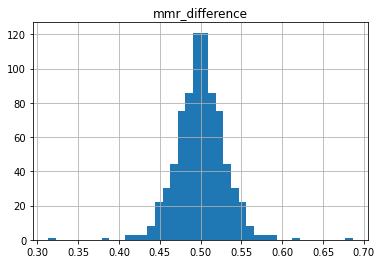

In [349]:
teams_df.hist(column='mmr_difference', bins=40) 

Text(0.5, 1.0, 'Relative hero experience')

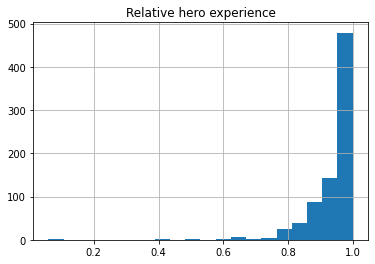

In [350]:
teams_df.hist(column='percent_rank_avg', bins=20)
plt.title('Relative hero experience') 

Text(0.5, 1.0, 'Team Hero-Score Average')

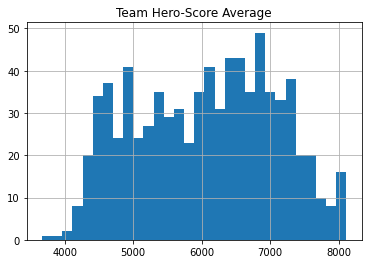

In [351]:
teams_df.hist(column='score_avg', bins=30)
plt.title('Team Hero-Score Average')


Text(0.5, 1.0, 'Team Rank distribution')

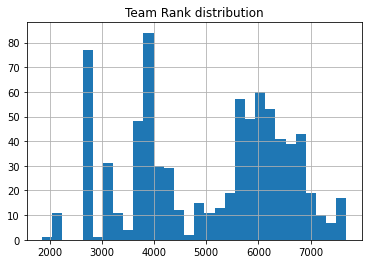

In [352]:
#teams_df.groupby('game_avg_mmr').count()
# teams_df['game_avg_mmr'] = teams_df['game_avg_mmr'].astype(int)

teams_df.hist(column='team_mmr_estimate', bins=30)
plt.title('Team Rank distribution') 



(4.45, 4.9)
(4.67, 5.12)


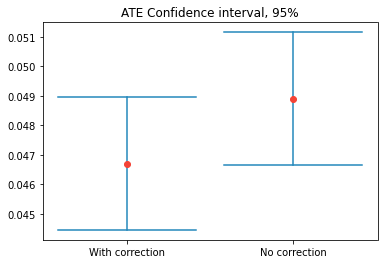

In [353]:
#normal distribution variance known
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / math.sqrt(len(values))
    print("(" + str(round((mean - confidence_interval)*100, 2)) + ', ' + str(round((mean + confidence_interval)*100, 2)) + ")")

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


plt.xticks([1, 1.3], ['With correction', 'No correction'])
plt.title('ATE Confidence interval, 95%')
m, ci =  plot_confidence_interval(1, l_ate)
n_m, n_ci = plot_confidence_interval(1.3, nl_ate)
plt.show()


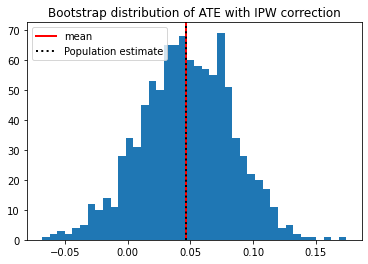

In [354]:
plt.title('Bootstrap distribution of ATE with IPW correction')

plt.hist(x=l_ate, bins=40)
plt.axvline(mean_ate, color='r', linestyle='solid', linewidth=2, label="mean")
plt.axvline(ate_population, color='k', linestyle='dotted', linewidth=2, label="Population estimate")
plt.legend(loc="upper left")

# red is mean ate
# black dotted is ate of population

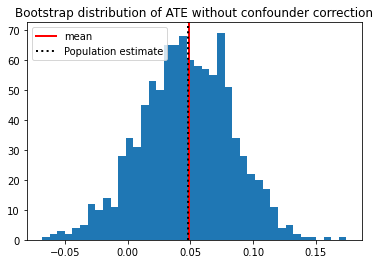

In [355]:

plt.title('Bootstrap distribution of ATE without confounder correction')

plt.hist(x=l_ate, bins=40)
plt.axvline(n_mean, color='r', linestyle='solid', linewidth=2, label="mean")
plt.axvline(n_ate_population, color='k', linestyle='dotted', linewidth=2, label="Population estimate")
plt.legend(loc="upper left")

# red is mean ate
# black dotted is ate of population

Text(0.5, 1.0, 'Inverse probability weights - Treatment')

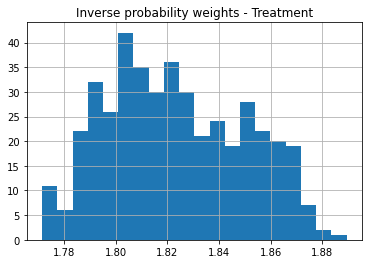

In [359]:
df_results_weigths[(df_results_weigths['treatment'] == 1)].hist(column='inverse_p_weight', bins=20)
plt.title('Inverse probability weights - Treatment') 

Text(0.5, 1.0, 'Inverse probability weights - No treatment')

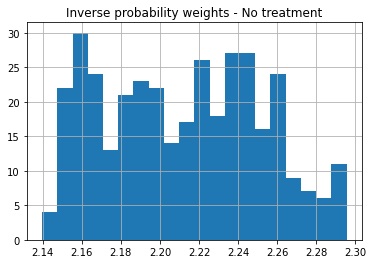

In [360]:
df_results_weigths[(df_results_weigths['treatment'] == 0)].hist(column='inverse_p_weight', bins=20)
plt.title('Inverse probability weights - No treatment') 